In [1]:
suppressMessages(library(tidyverse))
suppressMessages(library(SomaticSignatures))

In [2]:
suppressMessages(source("src/R/bio_utils.R"))
suppressMessages(source("src/R/data_utils.R"))
suppressMessages(source("src/R/plots.R"))

In [3]:
options(jupyter.plot_scale = 1)

In [4]:
# extract signatures from data (if not, are loaded from file)
c.extract_signatures <- FALSE

In [5]:
# Load SNVs
df <- read.csv("data/snv_list.csv", stringsAsFactors = FALSE)

In [6]:
# Make mutation tables for all snv and only ig ones
mutation_table_full <- make_mutation_table(df, lymph)
mutation_table_ig <-
  make_mutation_table(df %>% filter(ig == "True"), lymph) %>%
  dplyr::rename("IG CLL/MBL" = "CLL/MBL", "IG FL" = "FL")

# Combine mutation tables
mutation_table <-
  merge(mutation_table_full, mutation_table_ig, all = TRUE) %>%
  replace(is.na(.), 0)

## Mutational Profile

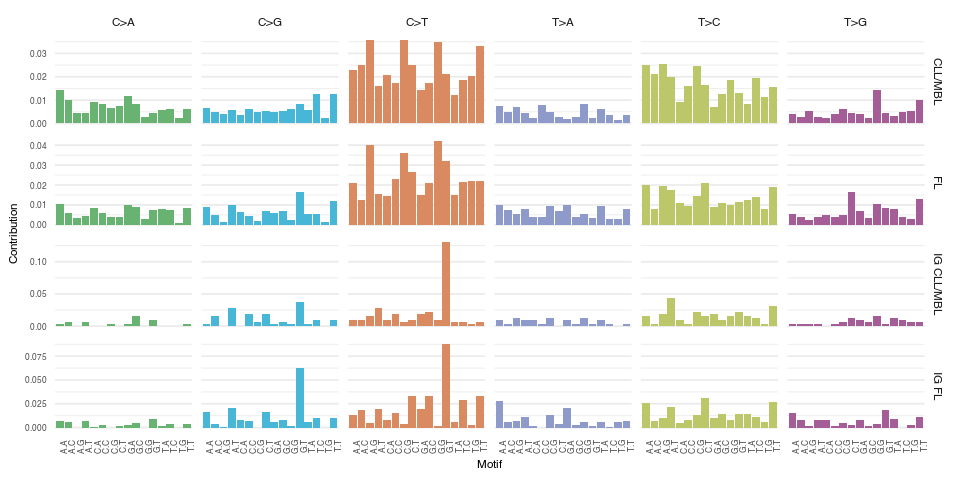

In [7]:
options(repr.plot.width = 8, repr.plot.height = 4)
print(plot_patterns(mutation_table))

In [8]:
# get signatures, either extracting them or loading from file
if (c.extract_signatures) {
  mt <- make_mutation_table(df, sample, normalize = FALSE) %>%
    `rownames<-`(paste(sub(">", "", .$substitution), .$context, sep = " ")) %>%
    dplyr::select(-c(substitution, context)) %>%
    as.matrix()

  sigs_nmf <- SomaticSignatures::identifySignatures(mt, 3, nmfDecomposition, nrun = 20)
} else {
  load(file = "../data/signatures_nmf.Rdata")
}

In [9]:
# transform the SomaticSignatures result to use our function to plot them
sigs <- t(t(sigs_nmf@signatures) / colSums(sigs_nmf@signatures)) # normalization
sigs <- as.data.frame(sigs) %>%
  rownames_to_column("r") %>%
  separate(r, c("substitution", "context"), sep = " ") %>%
  mutate(substitution = sub("^(.)(.)$", "\\1>\\2", substitution)) %>%
  dplyr::select(c("substitution", "context", "S1", "S2", "S3"))

## Signatures

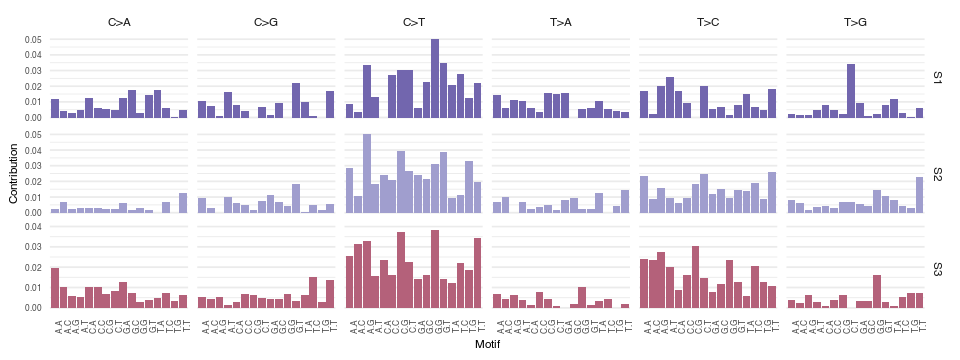

In [10]:
options(repr.plot.width = 8, repr.plot.height = 3)
print(plot_patterns(sigs, colorby = "sample"))